앞서 만든 경제 지표와 DD 값이 들어간 데이터를 사용해 DD 예측을 진행해보겠습니다.

# import

In [1]:
# !pip install -U finance-datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings("ignore")

# import FinanceDataReader as fdr

In [3]:
# 폰트 설정
import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'C:/Windows/Fonts',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

In [4]:
# # 설치된 폰트 리스트 확인
# import matplotlib.font_manager as fm

# font_list = [font.name for font in fm.fontManager.ttflist]
# print(font_list)

In [5]:
# plt 설정
# plt.rcParams["figure.figsize"] = (12,4)
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams["axes.grid"] = True

# pd.options.display.max_rows = 2000
# pd.options.display.max_columns = 100

# Load Data

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# base_path = '/content/drive/MyDrive/Colab Notebooks/YDS/project/Fianl Project/data/'
base_path = 'D:/coding/YDS/projects/final_project/data/'
# 여러 경제 지표들과 카카오 페이의 MDD 데이터
kakao_pay_df = pd.read_csv(base_path + 'Preprocessing_result.csv', index_col='Date')
kakao_pay_df.index = pd.to_datetime(kakao_pay_df.index)
dd = kakao_pay_df.Close # 이름 잘못 저장됨, 종가가 아니라 DD 값임
kakao_pay_df = kakao_pay_df.drop('Close', axis=1)
kakao_pay_df = kakao_pay_df.drop('뉴스감성지수', axis=1)


print(dd)
display(kakao_pay_df.tail())

Date
2021-11-03    0.000000
2021-11-04   -0.124352
2021-11-05   -0.119171
2021-11-08   -0.204663
2021-11-09   -0.238342
                ...   
2022-09-26   -0.777778
2022-09-27   -0.779455
2022-09-28   -0.786164
2022-09-29   -0.793501
2022-09-30   -0.794130
Name: Close, Length: 226, dtype: float64


,CD수익률(91일),KORIBOR(3개월),개인신용카드사용액,건설수주액,경기동행지수순환변동치,경기선행지수순환변동치,경상수지,경제심리지수,경제활동인구,고객예탁금,...,ma_5,ma_20,ma_60,bb_upper_band,bb_middle_band,bb_lower_band,macd,macd_signal,macd_hist,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-26,3.09,3.07,68073267.4,18650039.0,102.5,99.18,-4036.08,98.0,28937.75,50852276.0,...,57400.0,60045.0,64493.333333,63199.310304,57400.0,51600.689696,-2459.653605,-1980.504712,-479.148893,30.567868
2022-09-27,3.12,3.13,68073267.4,18650039.0,102.5,99.18,-4036.08,98.0,28937.75,50852276.0,...,55820.0,59490.0,64366.666667,61684.332869,55820.0,49955.667131,-2777.186639,-2139.841097,-637.345542,30.017390
2022-09-28,3.14,3.15,68073267.4,18650039.0,102.5,99.18,-4036.08,98.0,28937.75,50852276.0,...,53960.0,58985.0,64223.333333,58764.331379,53960.0,49155.668621,-3121.952559,-2336.263389,-785.689169,27.856440
2022-09-29,3.20,3.16,68073267.4,18650039.0,102.5,99.18,-4036.08,98.0,28937.75,50852276.0,...,52230.0,58327.5,64030.833333,56284.429676,52230.0,48175.570324,-3496.091641,-2568.229040,-927.862601,25.678970
2022-09-30,3.24,3.18,68073267.4,18650039.0,102.5,99.18,-4036.08,98.0,28937.75,50852276.0,...,50990.0,57672.5,63784.166667,54243.551905,50990.0,47736.448095,-3761.344863,-2806.852204,-954.492658,25.495011


# Preprocessing

## 상관관계 확인

<Axes: >

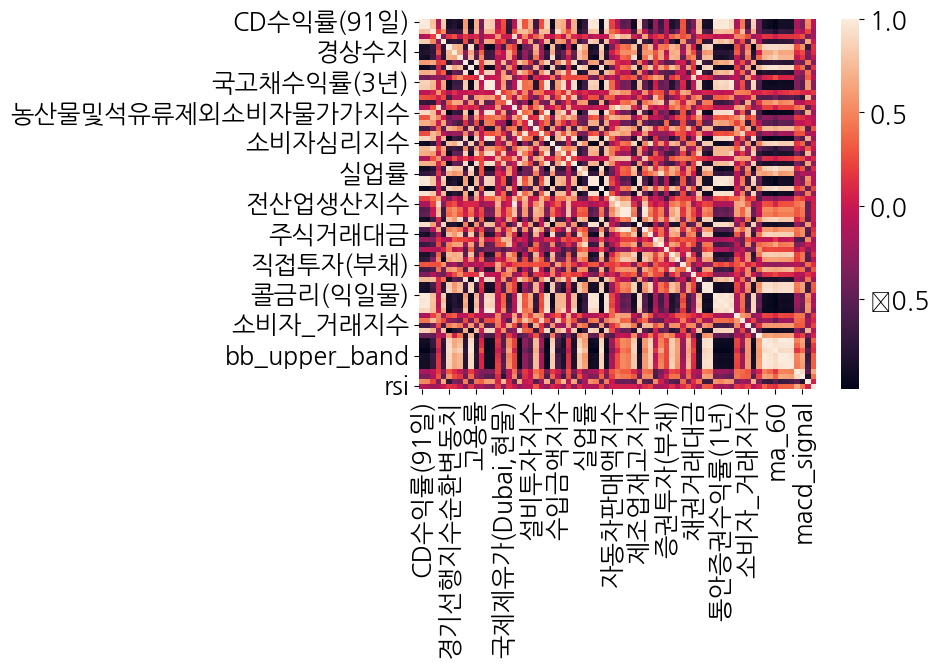

In [8]:
correlation = kakao_pay_df.corr()
display(sns.heatmap(correlation))

upper = correlation.abs().where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# 상관계수가 0.9 이상인 feature를 drop list에 추가
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

## 상관관계가 0.9 이상인 값들을 vif로 확인

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(train):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(train.values, i)for i in range(train.shape[1])]
    vif["features"] = train.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    return vif
vif = feature_engineering_XbyVIF(kakao_pay_df[to_drop])
pd.options.display.float_format = '{:.4f}'.format
vif

,VIF Factor,features
0,43.7306,macd_signal
1,43.8336,코스피지수
2,70.6082,원/달러환율
3,82.8428,콜금리(익일물)
4,94.0344,한국은행기준금리
5,168.4119,"회사채수익률(3년,_AA-)"
6,196.9002,ma_20
7,348.1837,통안증권수익률(1년)
8,416.7144,KORIBOR(3개월)
9,436.8131,ma_60


In [10]:
# 값이 10 이상인 feature들을 drop
kakao_pay_df = kakao_pay_df.drop(to_drop, axis=1)
len(kakao_pay_df.columns)

33

# train test split

In [11]:
kakao_pay_df['DD'] = dd

In [12]:
split_ratio = 0.9
split_num = int(len(kakao_pay_df) * split_ratio)
print(split_num)

train_X, train_y = kakao_pay_df.iloc[:split_num, :-1], kakao_pay_df.iloc[:split_num, -1]
test_X, test_y = kakao_pay_df.iloc[split_num:, :-1], kakao_pay_df.iloc[split_num:, -1]

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

203
(203, 33) (203,)
(23, 33) (23,)


# feature 우선순위 상위 20위 확인

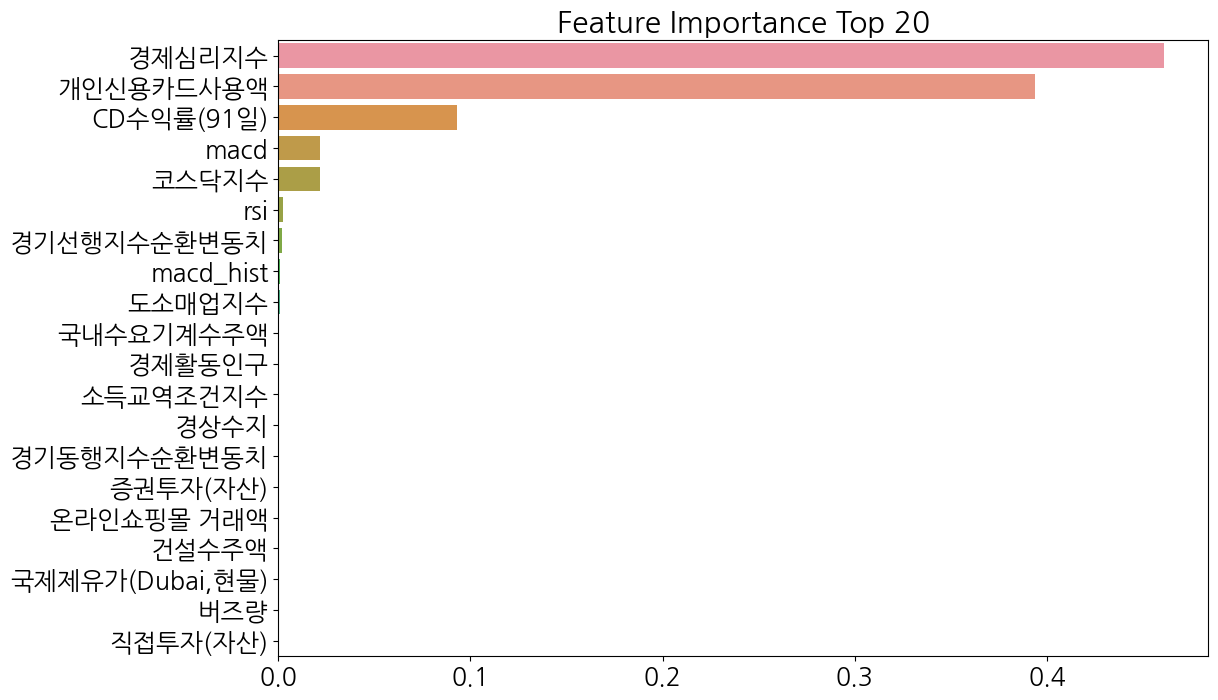

In [13]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42)
model.fit(train_X, train_y)

# 배열형태로 반환
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = train_X.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(12,8))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

# Modeling

## ARIMA

In [14]:
import pmdarima as pm
from pmdarima.arima import ndiffs

target값 그래프로 확인

<Axes: xlabel='Date'>

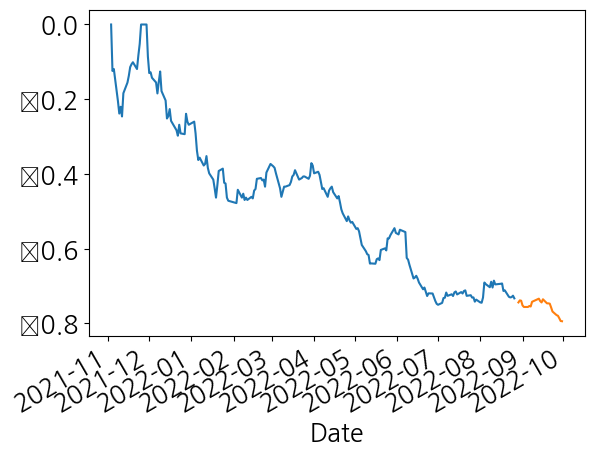

In [15]:
train_y.plot()
test_y.plot()

In [16]:
kpss_diffs = ndiffs(train_y, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_y, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


모델 학습

In [17]:
model = pm.auto_arima(y = train_y       # 데이터
                      , d = 1           # (d)차분 차수 (기본값 = none), 지정하지 않으면 실행 기간이 매우 길어질 수 있음
                      , start_p = 0     # (p)탐색 시초값 (기본값 = 2)
                      , max_p = 3       # (기본값 = 5)
                      , start_q = 0     # (q)탐색 시초값 (기본값 = 2)
                      , max_q = 3       # (기본값 = 5)
                      , m = 1           # (기본값 = 1)
                      , seasonal = False # 기본값 = True, 계절변동 ARIMA(SARIMA)에 해당시 True로 수정
                      , stepwise = True  
                      , trace=True      # stepwise로 모델을 적합할 때마다 결과를 프린트
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-951.695, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-951.949, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-951.563, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-948.608, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-951.908, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-951.164, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-949.070, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-949.796, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.341 seconds


잔차 검정

잔차가 백색잡음 과정인지 (=정상성을 만족하는지), 정규성 및 등분산성을 만족하는지 파악

1. summary 결과에서 Ljung-Box (Q) / Heteroskedasticity (H) / Jarque-Bera (JB) 검정 만족 여부를 파악
2. plot_diagnostics 잔차 그래프로 정상성과 정규성을 만족하는지 파악

In [18]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 478.975
Date:                Thu, 14 Sep 2023   AIC                           -951.949
Time:                        22:20:43   BIC                           -942.024
Sample:                             0   HQIC                          -947.934
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0033      0.002     -1.895      0.058      -0.007       0.000
ar.L1          0.1138      0.070      1.615      0.106      -0.024       0.252
sigma2         0.0005   2.98e-05     17.103      0.0

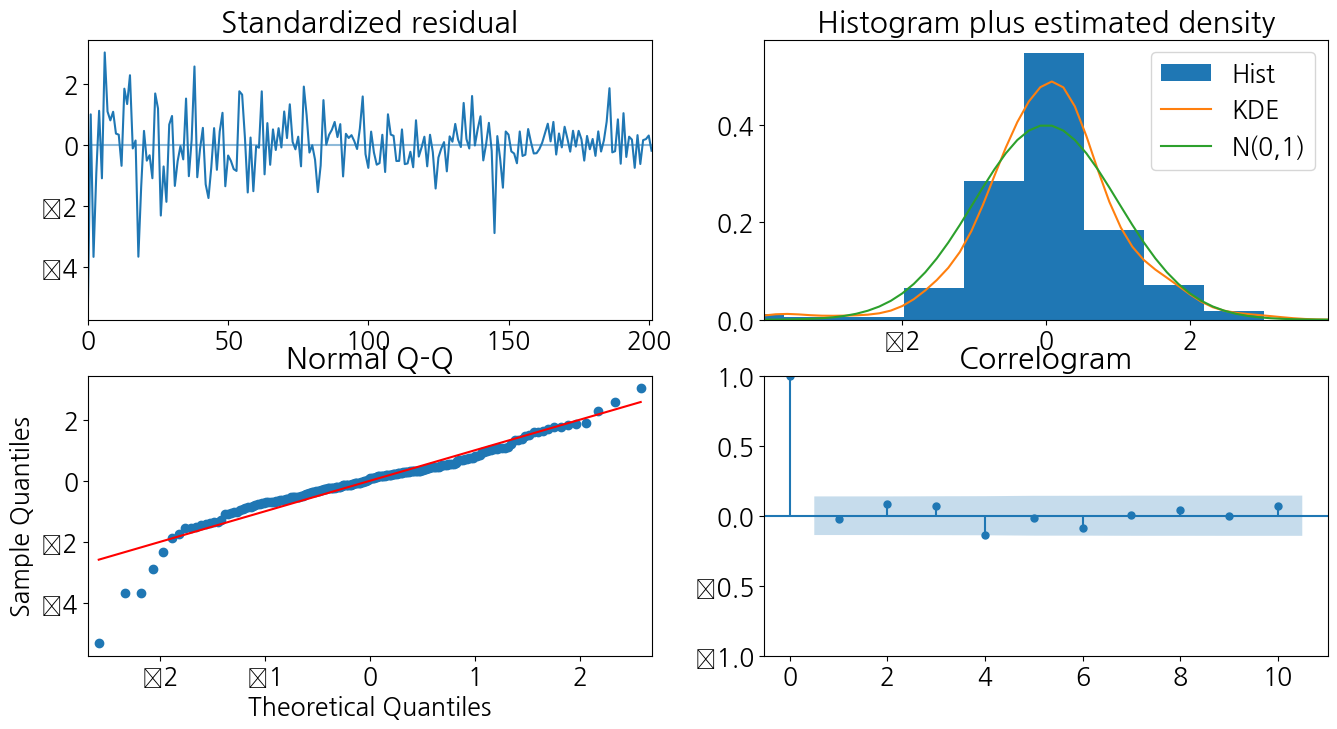

In [19]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

예측 진행

c:\Users\sunse\miniconda3\envs\coding\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


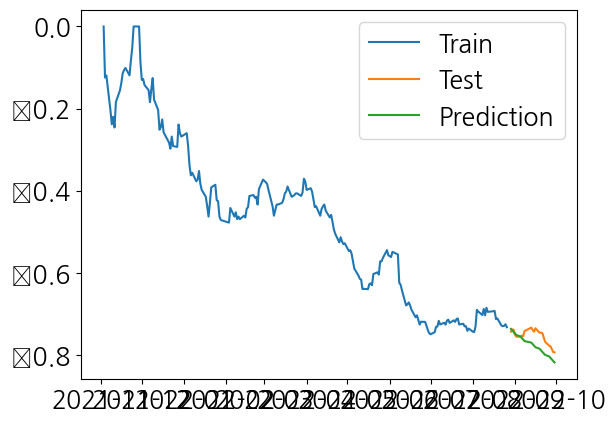

In [20]:
# 테스트 데이터 개수만큼 예측
predict = model.predict(n_periods=len(test_y))
# 시각화
predict = pd.DataFrame(list(predict), index=test_y.index)
fig, axes = plt.subplots(1, 1)
plt.plot(train_y, label='Train')        # 훈련 데이터
plt.plot(test_y, label='Test')          # 테스트 데이터
plt.plot(predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

예측한 값을 토대로 한 스탭식 반복 예측

In [21]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)               
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [22]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in test_y:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트
    model.update(new_ob)

c:\Users\sunse\miniconda3\envs\coding\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


결과 확인

In [23]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  226
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 544.490
Date:                Thu, 14 Sep 2023   AIC                          -1082.981
Time:                        22:20:46   BIC                          -1072.732
Sample:                             0   HQIC                         -1078.844
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0032      0.002     -2.037      0.042      -0.006      -0.000
ar.L1          0.1138      0.064      1.781      0.075      -0.011       0.239
sigma2         0.0005   2.43e-05     19.009      0.0

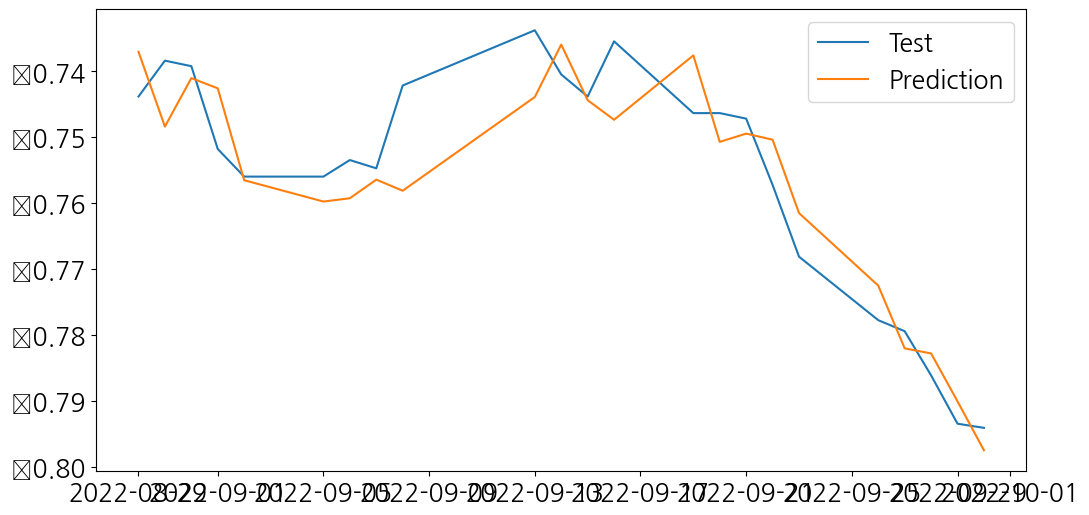

In [24]:
y_pred = pd.DataFrame(y_pred, index=test_y.index)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# plt.plot(train_y, label='Train')
plt.plot(test_y, label='Test')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.show()

MAPE(mean absolute percentage error)를 사용한 모델 평가

In [25]:
def MAPE(y_test, y_pred): 
	return np.mean(np.abs((test_y - y_pred) / y_test)) * 100 
    
print(f"MAPE (%): {MAPE(test_y, y_pred):.3f}")

MAPE (%): nan


## LSTM

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

device 설정

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(device)

cpu


seed 설정

In [28]:
torch.manual_seed(42)

In [29]:
# # 데이터를 역순으로 정렬(역시간순 -> 시간순)
# df = df[::-1]

In [30]:
scaler = MinMaxScaler()
scaler.fit(train_X)

scaled_train_X = scaler.transform(train_X)
scaled_test_X = scaler.transform(test_X)

# print(scaled_train_X, scaled_test_X)

DataLoader

In [31]:
batch_size = 64

In [53]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_X_ = torch.tensor(train_X.values).to(torch.float32)
train_y_ = torch.tensor(train_y.values).to(torch.float32)

test_X_ = torch.tensor(test_X.values).to(torch.float32)
test_y_ = torch.tensor(test_y.values).to(torch.float32)

train_loader = DataLoader(
        dataset=TensorDataset(train_X_, train_y_), 
        batch_size=batch_size, 
        shuffle=True
    )

파라미터 설정

In [33]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
input_size = len(train_X.columns)

커스텀 모델

In [45]:
class LSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        n_layers=4,
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.layers = nn.Sequential(
            # nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        # |x| = (batch_size, h, w)

        z, _ = self.lstm(x)
        # |z| = (batch_size, h, hidden_size * 2)
        # print("1", z.shape)
        # z = z[:, -1]
        # |z| = (batch_size, hidden_size * 2)
        # print("2", z.shape)
        y = self.layers(z)
        # |y| = (batch_size, output_size)
        # print("3", y.shape)

        return y



학습 함수

In [66]:
def train_model(model, train_loader, num_epochs = 1000, verbose = 0, interval = 10):
    model.train()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_hist = []
    for epoch in range(num_epochs):
        train_loss = 0

        for x_i, y_i in train_loader:
            # print(x_i.shape, x_i.dtype)
            # print(y_i.shape, type(y_i))
            y_pred = model(x_i)

            loss = criterion(y_pred, y_i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss

        train_hist.append(train_loss/len(train_loader))

        if epoch+1 % interval == 0:
            print(f'epoch {epoch+1}/{num_epochs}: train loss={train_loss:2e}')
            
    return model, train_hist

모델 학습 진행

In [67]:
lstm = LSTM(input_size, 10, 1).to(device)

model, train_hist = train_model(lstm, train_loader)

결과 확인

In [68]:
# # epoch별 손실값
# fig = plt.figure(figsize=(10, 4))
# plt.plot(train_hist, label="Training loss")
# plt.legend()
# plt.show()

In [69]:
# # 모델 저장    
# PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
# torch.save(model.state_dict(), PATH)

# # 불러오기
# model = lstm(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
# model.load_state_dict(torch.load(PATH), strict=False)
# model.eval()

In [70]:
model.eval()

with torch.no_grad():
    y_pred = model(test_X_)

# print(y_pred)

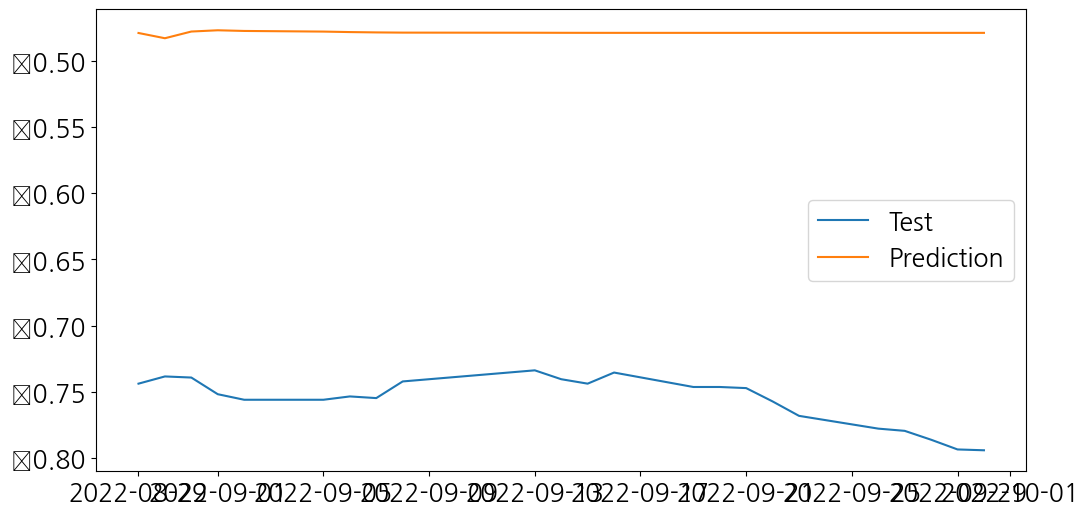

In [71]:
y_pred = pd.DataFrame(y_pred, index=test_y.index)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# plt.plot(train_y, label='Train')
plt.plot(test_y, label='Test')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.show()

In [65]:
# fig = plt.figure(figsize=(12,6))
# plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
# plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
# plt.title("Loss plot")
# plt.show()